In [7]:
import os

import numpy as np
import pandas as pd
from typing import Dict, List
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sn
%matplotlib inline


# path = "C:\\Users\\jerchen\\PythonDeveloper\\2021 Quant Programming Task\\2021 Quant Programming Task\\mkt_data"
path = "./mkt_data/"
dir_list = os.listdir(path)
all_data = []
for rd in dir_list:
    print('reading ', rd, '...')
    raw_data = pd.read_csv(path + '/' + rd)
    raw_data['ticker'] = str(rd)[:-4]
    all_data.append(raw_data)
print('all data len ', len(all_data))

#
def cln_df(df: pd.DataFrame):
    cols: List[str] = df.columns
    for col in cols:
        if ' ' in col:
            col_name = col.strip()
            df[col_name] = df[col]
            del df[col]
    return df

all_data = [cln_df(data) for data in all_data]

reading  BLDE.csv ...
reading  TECH.csv ...
reading  SMTC.csv ...
reading  AMZN.csv ...
reading  SHOO.csv ...
reading  PRTS.csv ...
reading  CAL.csv ...
reading  KXIN.csv ...
reading  TTGT.csv ...
reading  XOS.csv ...
all data len  10


In [8]:
def datetime_from_millis(millisec):
    return pd.Timestamp.fromtimestamp(millisec/1000)
def convert_timestamp(df: pd.DataFrame):
    df['time'] = [datetime_from_millis(x) for x in df['timestamp']]
    return df
all_data = [convert_timestamp(data) for data in all_data]

In [9]:
all_data[0][['timestamp','time']]

,timestamp,time
0,1635341400380,2021-10-27 09:30:00.380
1,1635341400481,2021-10-27 09:30:00.481
2,1635341400527,2021-10-27 09:30:00.527
3,1635341400554,2021-10-27 09:30:00.554
4,1635341400555,2021-10-27 09:30:00.555
...,...,...
6274,1635364794789,2021-10-27 15:59:54.789
6275,1635364795073,2021-10-27 15:59:55.073
6276,1635364795878,2021-10-27 15:59:55.878
6277,1635364799229,2021-10-27 15:59:59.229


In [153]:
# from datetime import timedelta
# import time
# from pytz import timezone

# def datetime_from_millis(millisec):
#     return pd.to_datetime(datetime.fromtimestamp(millisec/1000, timezone("US/Eastern")).isoformat('T', 'milliseconds'))
# def convert_timestamp(df: pd.DataFrame):
#     df['time'] = [datetime_from_millis(x) for x in df['timestamp']]
#     return df
# all_data = [convert_timestamp(data) for data in all_data]

In [10]:
def get_target_cols(df:pd.DataFrame):
    df['non_cum_vol'] = df["volume"].diff().fillna(df['volume'].iloc[0])
    df['vol %'] = df['non_cum_vol']/(df['volume'].iloc[-1])
    df['spread'] = df['ask_price'] - df['bid_price']
    return df


all_data = [get_target_cols(data) for data in all_data]

In [11]:
def create_15min_agg_data(df:pd.DataFrame):
    try:
        data_15min = df.set_index('time').groupby(pd.Grouper(freq='15min')).agg({'spread': 'mean', 'vol %': 'mean', 'vwap': 'mean'})
        data_15min['ticker'] = df['ticker'].iloc[0]
        # data_15min = data_15min.reset_index()
        return data_15min
    except Exception as e:
        print('error at ticker', df['ticker'].iloc[0])
        print(e)
        print("---")
all_15min_data = [create_15min_agg_data(data) for data in all_data.copy()]

In [5]:
agg_data = pd.concat(all_15min_data, axis=0)
agg_data

,spread,vol %,vwap,ticker
time,,,,
2021-10-27 09:30:00,0.053575,0.000280,9.780177,BLDE
2021-10-27 09:45:00,0.028989,0.000312,9.827371,BLDE
2021-10-27 10:00:00,0.022069,0.000204,9.838340,BLDE
2021-10-27 10:15:00,0.017911,0.000240,9.843054,BLDE
2021-10-27 10:30:00,0.016708,0.000280,9.850086,BLDE
...,...,...,...,...
2021-10-27 15:00:00,0.010000,0.000113,4.543018,XOS
2021-10-27 15:15:00,0.010623,0.000083,4.541534,XOS
2021-10-27 15:30:00,0.012820,0.000103,4.539173,XOS


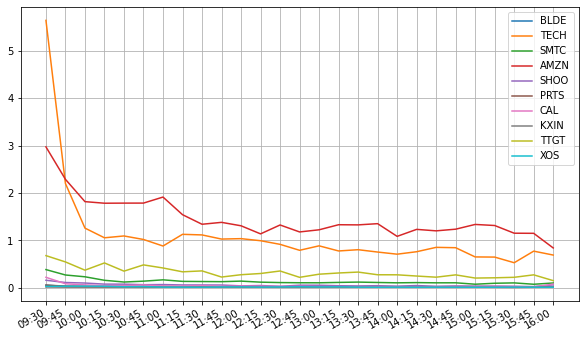

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

def plot_15min_data(data_15min: List[pd.DataFrame], on_col: str):
    fig, ax = plt.subplots(figsize=(10, 6))

    for idx, data in enumerate(data_15min):
        ax.plot(data.index, data[on_col], label=data['ticker'].iloc[0])

        labels = [str(x)[-8:-3] for x in data.index]
        plt.xticks(ticks=all_15min_data[0].index, labels=labels)

        ax.xaxis_date()
        fig.autofmt_xdate()

        # myLocator = mticker.IndexLocator(base=4, offset=8)
        # ax.xaxis.set_major_locator(myLocator)
    ax.grid()
    plt.legend()
    plt.show()
plot_15min_data(all_15min_data, 'spread')

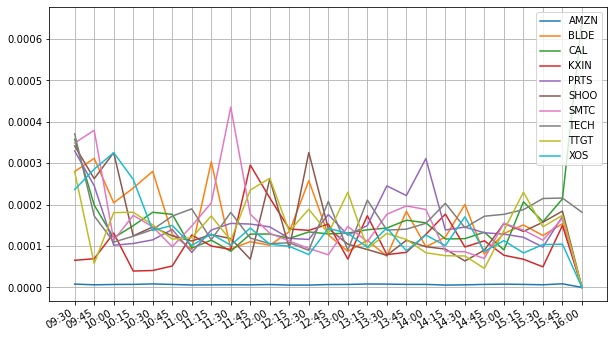

In [10]:
plot_15min_data(all_15min_data, 'vol %')

In [27]:
# import seaborn as sns
# import numpy as np
# def plot_vwap_dist(pdf):
#     agg_data = pd.concat(pdf).reset_index()
#     agg_data = agg_data[['time', 'ticker', 'vwap']]
#     sns.catplot(x=agg_data.ticker, y=agg_data.vwap,  kind='box')
#
# plot_vwap_dist(all_15min_data, 'vwap')
# import plotly.graph_objects as go
#
# fig = go.Figure()
# fig.add_trace(go.Histogram(x=log_returns.COST, name='COST'))
# fig.add_trace(go.Histogram(x=log_returns.NIO, name='NIO'))
# fig.add_trace(go.Histogram(x=log_returns.AMD, name='AMD'))
#
# fig.update_xaxes(range=[log_min, log_max])
# fig.update_layout(autosize=True, height=450, barmode='overlay', title='Log returns: COST,NIO,AMD')
# fig.update_traces(opacity=0.5)
# fig.show()

## Question 2

### prepare normalized mid price

In [12]:
data1: pd.DataFrame = all_data[0].copy()
data1.columns

Index(['timestamp', 'ticker', 'bid_price', 'bid_size', 'bid_exchange',
       'ask_price', 'ask_size', 'ask_exchange', 'trade_price', 'trade_size',
       'trade_exchange', 'volume', 'notional_volume', 'vwap', 'nbb_agg_size',
       'nbb_no_of_exchange', 'nbo_agg_size', 'nbo_no_of_exchange',
       'is_odd_lot', 'is_hidden_order', 'is_mid_order', 'is_buy_order',
       'is_sell_order', 'is_trade_through', 'time', 'non_cum_vol', 'vol %',
       'spread'],
      dtype='object')

In [147]:
data1[['time', 'ticker', 'bid_price', 'ask_price', 'spread', 'volume','vol %']].head()

,time,ticker,bid_price,ask_price,spread,volume,vol %
0,2021-10-27 09:30:00.380,BLDE,9.75,9.98,0.23,6667,0.016085
1,2021-10-27 09:30:00.481,BLDE,9.75,9.97,0.22,7384,0.001730
2,2021-10-27 09:30:00.527,BLDE,9.75,9.97,0.22,7466,0.000198
3,2021-10-27 09:30:00.554,BLDE,9.75,9.97,0.22,7566,0.000241
4,2021-10-27 09:30:00.555,BLDE,9.75,9.97,0.22,7666,0.000241


In [142]:
# pd.to_datetime(data1['time'].dt.strftime('%H:%M:%S:%f')[:-3])

In [13]:
# # def get_mid_prc_ret(pdf):
# mask1 = data1['spread'] <= 0
# data1 = data1[~mask1]
# data1['time'] = data1['time'].dt.strftime('%H:%M:%S:%f')#.str[:-3] 
data1 = data1.set_index('time')
data1['mid_price'] = (data1['bid_price'] + data1['ask_price'])/2

data1['mid_price'].head(15)

time
2021-10-27 09:30:00.380    9.865
2021-10-27 09:30:00.481    9.860
2021-10-27 09:30:00.527    9.860
2021-10-27 09:30:00.554    9.860
2021-10-27 09:30:00.555    9.860
2021-10-27 09:30:04.082    9.840
2021-10-27 09:30:04.175    9.840
2021-10-27 09:30:05.734    9.840
2021-10-27 09:30:33.630    9.810
2021-10-27 09:31:45.598    9.790
2021-10-27 09:31:59.580    9.790
2021-10-27 09:32:03.363    9.790
2021-10-27 09:32:09.201    9.790
2021-10-27 09:32:11.177    9.790
2021-10-27 09:32:11.189    9.785
Name: mid_price, dtype: float64

In [14]:
data_1 = data1[['mid_price', 'ticker', 'bid_price', 'ask_price', 'spread',]].copy()
data_1.head(20)
# agg.stack(0).T.diff().dropna().squeeze().unstack()
# mid_10s_ret = mid_10s_agg.stack().pct_change()
# mid_10s_ret = mid_10s_ret.droplevel(1)
# mid_10s_ret

,mid_price,ticker,bid_price,ask_price,spread
time,,,,,
2021-10-27 09:30:00.380,9.865,BLDE,9.75,9.98,0.23
2021-10-27 09:30:00.481,9.860,BLDE,9.75,9.97,0.22
2021-10-27 09:30:00.527,9.860,BLDE,9.75,9.97,0.22
2021-10-27 09:30:00.554,9.860,BLDE,9.75,9.97,0.22
2021-10-27 09:30:00.555,9.860,BLDE,9.75,9.97,0.22
2021-10-27 09:30:04.082,9.840,BLDE,9.75,9.93,0.18
2021-10-27 09:30:04.175,9.840,BLDE,9.75,9.93,0.18
2021-10-27 09:30:05.734,9.840,BLDE,9.75,9.93,0.18
2021-10-27 09:30:33.630,9.810,BLDE,9.75,9.87,0.12


In [15]:
mid_10s_agg = data_1['mid_price'].groupby(pd.Grouper(freq='10S')).agg(['last'])
mid_10s_agg.shift(1).head(20)

,last
time,
2021-10-27 09:30:00,NaN
2021-10-27 09:30:10,9.84
2021-10-27 09:30:20,NaN
2021-10-27 09:30:30,NaN
2021-10-27 09:30:40,9.81
2021-10-27 09:30:50,NaN
2021-10-27 09:31:00,NaN
2021-10-27 09:31:10,NaN
2021-10-27 09:31:20,NaN


In [106]:
mid_10s_agg.shift(1).tail(20)

,last
time,
2021-10-27 15:56:50,9.575
2021-10-27 15:57:00,9.575
2021-10-27 15:57:10,9.575
2021-10-27 15:57:20,9.575
2021-10-27 15:57:30,9.575
2021-10-27 15:57:40,9.575
2021-10-27 15:57:50,9.575
2021-10-27 15:58:00,9.575
2021-10-27 15:58:10,9.580


In [16]:
mid_10s_res = data_1['mid_price'].resample('10S').last().to_frame()
mid_10s_res.rename(columns={'mid_price':'last_mid_price'},inplace=True)
# mid_10s_res
mid_10s_res = mid_10s_res.shift(1)
mid_10s_aggall = data_1.join(mid_10s_res, how='outer').reindex()
mid_10s_aggall['last_mid_price_cln'] = mid_10s_aggall['last_mid_price'].bfill()
mid_10s_aggall = mid_10s_aggall.dropna(subset=['spread'])
mid_10s_aggall.drop(columns=['last_mid_price'], axis=0, inplace=True)
mid_10s_aggall['timestamp'] = mid_10s_aggall.index.strftime('%H:%M:%S:%f')
mid_10s_aggall.head()

,mid_price,ticker,bid_price,ask_price,spread,last_mid_price_cln,timestamp
time,,,,,,,
2021-10-27 09:30:00.380,9.865,BLDE,9.75,9.98,0.23,9.84,09:30:00:380000
2021-10-27 09:30:00.481,9.860,BLDE,9.75,9.97,0.22,9.84,09:30:00:481000
2021-10-27 09:30:00.527,9.860,BLDE,9.75,9.97,0.22,9.84,09:30:00:527000
2021-10-27 09:30:00.554,9.860,BLDE,9.75,9.97,0.22,9.84,09:30:00:554000
2021-10-27 09:30:00.555,9.860,BLDE,9.75,9.97,0.22,9.84,09:30:00:555000


In [176]:
mid_10s_aggall['mid_ret'] = mid_10s_aggall['last_mid_price_cln']/mid_10s_aggall['mid_price'] - 1
mid_10s_aggall.head(20)

,mid_price,ticker,bid_price,ask_price,spread,last_mid_price_cln,timestamp,mid_ret
time,,,,,,,,
2021-10-27 09:30:00.380,9.865,BLDE,9.75,9.98,0.23,9.84,09:30:00:380000,-0.002534
2021-10-27 09:30:00.481,9.860,BLDE,9.75,9.97,0.22,9.84,09:30:00:481000,-0.002028
2021-10-27 09:30:00.527,9.860,BLDE,9.75,9.97,0.22,9.84,09:30:00:527000,-0.002028
2021-10-27 09:30:00.554,9.860,BLDE,9.75,9.97,0.22,9.84,09:30:00:554000,-0.002028
2021-10-27 09:30:00.555,9.860,BLDE,9.75,9.97,0.22,9.84,09:30:00:555000,-0.002028
2021-10-27 09:30:04.082,9.840,BLDE,9.75,9.93,0.18,9.84,09:30:04:082000,0.000000
2021-10-27 09:30:04.175,9.840,BLDE,9.75,9.93,0.18,9.84,09:30:04:175000,0.000000
2021-10-27 09:30:05.734,9.840,BLDE,9.75,9.93,0.18,9.84,09:30:05:734000,0.000000
2021-10-27 09:30:33.630,9.810,BLDE,9.75,9.87,0.12,9.81,09:30:33:630000,0.000000


In [181]:
mid_10s_aggall.shape

(6279, 8)

### prepare predictors

In [17]:
mask = mid_10s_aggall.index
data1_1 = data1.loc[mask]
data1_1

,timestamp,ticker,bid_price,bid_size,bid_exchange,ask_price,ask_size,ask_exchange,trade_price,trade_size,...,is_odd_lot,is_hidden_order,is_mid_order,is_buy_order,is_sell_order,is_trade_through,non_cum_vol,vol %,spread,mid_price
time,,,,,,,,,,,,,,,,,,,,,
2021-10-27 09:30:00.380,1635341400380,BLDE,9.75,1100,XNAS,9.98,100,XNAS,9.770,10,...,1,1,0,0,1,0,6667.0,0.016085,0.23,9.865
2021-10-27 09:30:00.481,1635341400481,BLDE,9.75,1100,XNAS,9.97,1000,IEXG,9.770,717,...,0,1,0,0,1,0,717.0,0.001730,0.22,9.860
2021-10-27 09:30:00.527,1635341400527,BLDE,9.75,1100,XNAS,9.97,1000,IEXG,9.770,82,...,1,1,0,0,1,0,82.0,0.000198,0.22,9.860
2021-10-27 09:30:00.554,1635341400554,BLDE,9.75,1100,XNAS,9.97,1000,IEXG,9.860,100,...,0,1,1,0,0,0,100.0,0.000241,0.22,9.860
2021-10-27 09:30:00.555,1635341400555,BLDE,9.75,1100,XNAS,9.97,1000,IEXG,9.860,100,...,0,1,1,0,0,0,100.0,0.000241,0.22,9.860
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-27 15:59:54.789,1635364794789,BLDE,9.57,500,IEXG,9.59,700,XNAS,9.590,6,...,1,0,0,1,0,0,6.0,0.000014,0.02,9.580
2021-10-27 15:59:55.073,1635364795073,BLDE,9.57,200,XBOS,9.59,700,XNAS,9.590,17,...,1,0,0,1,0,0,17.0,0.000041,0.02,9.580
2021-10-27 15:59:55.878,1635364795878,BLDE,9.57,500,IEXG,9.59,1000,XNAS,9.590,7,...,1,0,0,1,0,0,7.0,0.000017,0.02,9.580
